# Generating metrics for selected baselines

In [ ]:
import os
import logging

import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
import scvi

import sys
from sc_foundation_evals import utils
from sc_foundation_evals.helpers.custom_logging import log

log.setLevel(logging.INFO)

import warnings
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

Specifying necessary variables, including path to anndata and names of columns with cell type labels and batch labels. I will be using the Pancreas dataset as an example, as described in the scGPT_zer-shot notebook.

In [ ]:
# specify the path to anndata object
adata_path = "zero_shot_batch_data/pancreas.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(adata_path).split(".")[0]

# batch column found in adata.obs
batch_col = "batch"
# where are labels stored in adata.obs? 
label_col = "celltype"
# where the raw counts are stored?
layer_key = "counts"

Reading the anndata.

In [3]:
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'batch'
    layers: 'counts'

If the raw data is stored in `X` or other layer instead of `counts`, we need to copy it to counts to be able to use it in scVI.

In [4]:
if layer_key == "X":
    adata.layers["counts"] = adata.X
elif layer_key != "counts":
    adata.layers["counts"] = adata.layers[layer_key]

Here, I opted for minimal preprocessing, similar to this suggested by Geneformer.

In [5]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Highly variable genes

For first baseline, I selected 2000 highly variable genes (HVGs) using `scanpy.pp.highly_variable_genes` with default parameters. I do not want the adata to be subsetted, so I set `subset=False` and save the created cell embedding space to `adata.obsm['X_hvg']`.

In [6]:
sc.pp.highly_variable_genes(adata, flavor='seurat', subset=False, n_top_genes=2000)

adata.obsm["X_genes"] = adata.X[:, adata.var.highly_variable.values]

# check if adata.obsm["X_genes"] is sparse and if so, convert to dense
if sparse.issparse(adata.obsm["X_genes"]):
    adata.obsm["X_genes"] = np.asarray(adata.obsm["X_genes"].todense())

Calculating metrics similiarly to those calculated for Geneformer and scGPT.

In [7]:
scib_metrics = utils.eval_scib_metrics(adata, 
                                       batch_key=batch_col, 
                                       label_key=label_col,
                                       embedding_key="X_genes")

In [8]:
(scib_metrics)

{'NMI_cluster/label': 0.7003624430820531,
 'ARI_cluster/label': 0.4701226289442969,
 'ASW_label': 0.5141745712608099,
 'graph_conn': 0.877999727358774,
 'ASW_batch': 0.4712261650711298,
 'ASW_label/batch': 0.8851817055731181,
 'PCR_batch': 0.21440366886552753,
 'avg_bio': 0.5615532144290533}

To visualize, we will use the umap plotting function from scanpy.

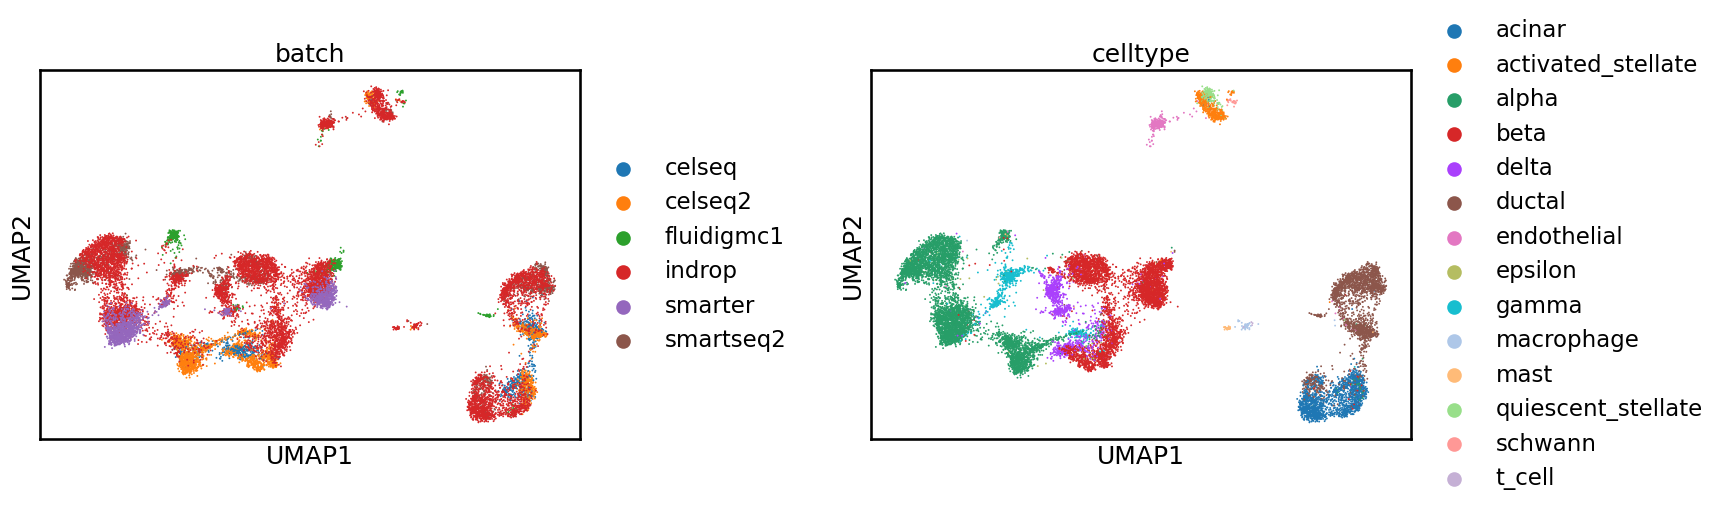

In [9]:
sc.pp.neighbors(adata, use_rep="X_genes")
sc.tl.umap(adata, min_dist = 0.3)
sc.pl.umap(adata, color=[batch_col, label_col], wspace = 0.4)

## scVI

As the other baseline, we look at the scVI model, which is a VAE model. To read more about it please refer to [scvi-tools manual](https://docs.scvi-tools.org/en/stable/user_guide/models/scvi.html) or [its publication](https://www.nature.com/articles/s41592-018-0229-2/).

In [10]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key=batch_col)

Specifying the model and training it.

In [11]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [12]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


Saving the cell embedding space to `adata.obsm['X_scvi']`.

In [13]:
adata.obsm["X_scVI"] = model.get_latent_representation()

Calculating metrics similarly to those calculated for Geneformer and scGPT.

In [14]:
scib_metrics = utils.eval_scib_metrics(adata, 
                                       batch_key=batch_col, 
                                       label_key=label_col,
                                       embedding_key="X_scVI")

WARNING  | 2025-06-21 18:17:07 | neighbors in adata.uns found 
 {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'X_genes'}} 
to make sure the optimal clustering is calculated for the correct embedding, removing neighbors from adata.uns.
Overwriting calculation of neighbors with sc.pp.neighbors(adata, use_rep=X_scVI).
INFO     | 2025-06-21 18:17:08 | neighbors in adata.uns removed, new neighbors calculated: {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'X_scVI'}}


In [15]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist = 0.3)

In [16]:
scib_metrics

{'NMI_cluster/label': 0.9116021084802223,
 'ARI_cluster/label': 0.9472485678781978,
 'ASW_label': 0.5707101002335548,
 'graph_conn': 0.9841929650494505,
 'ASW_batch': 0.45828261226415634,
 'ASW_label/batch': 0.8447735160205406,
 'PCR_batch': 0.03311276239379106,
 'avg_bio': 0.809853592197325}

Visualizing the cell embedding space.

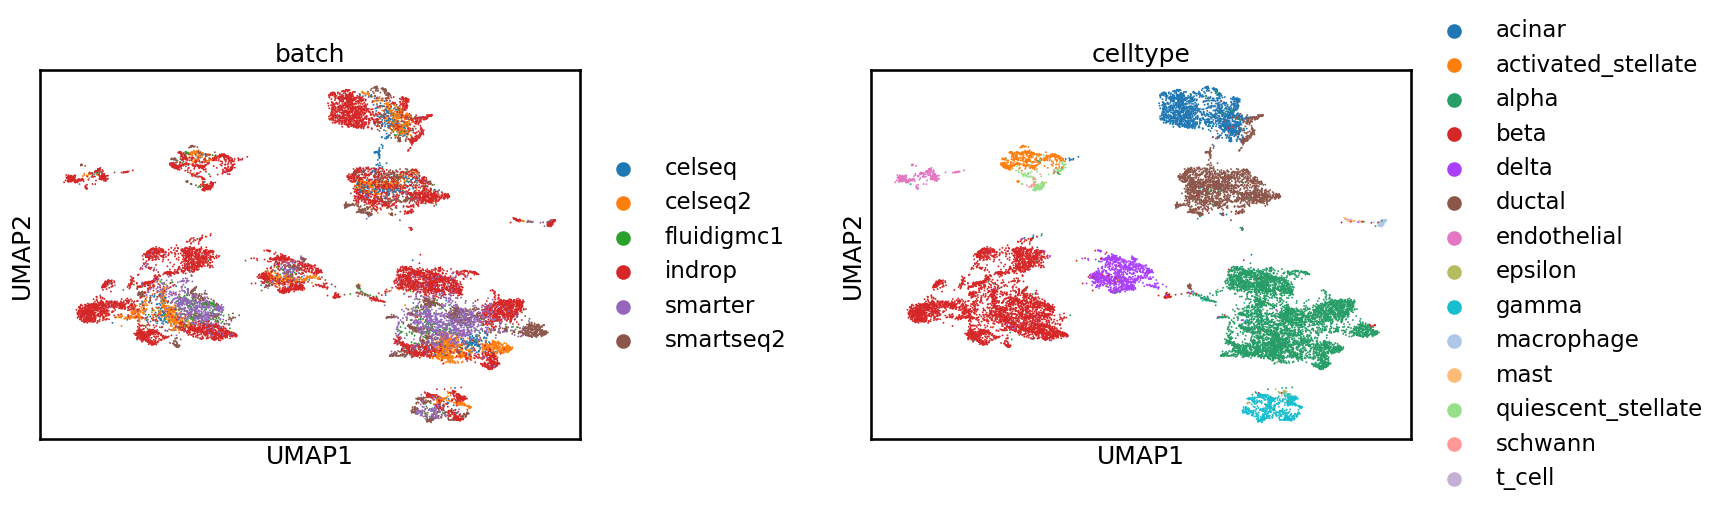

In [17]:
sc.pl.umap(adata, color=[batch_col, label_col], wspace = 0.4)